## How do environmental factors (vapor pressure deficit (VPD), and soil volumetric water content (VWC)) interact to influence radial stem growth of white spruce trees at Arctic treeline?


In [145]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [146]:
# Importing data
df = pd.read_csv('Final_app_work/categorized_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,site,tree,plot,species,Date,longitude,latitude,da,mo,wk,...,average_humidity,avg_solar_irradiance,avg_soil_water_content,freeze_flag,air_pressure_cat,humidity_cat,solar_rank,solar_cat,soil_moist_cat,growth_category
0,AK,1A,1,P glauca,2019-01-01,-149.71571,68.018576,1,1,1,...,0.840035,0.000000,0.077694,1,low,dry,1.0,Q1,dry,A Lot of Growth
1,AK,1A,1,P glauca,2019-02-01,-149.71571,68.018576,1,2,5,...,0.763849,3.239314,0.073754,1,medium,dry,2250.0,Q1,dry,A Little Growth
2,AK,1A,1,P glauca,2019-05-01,-149.71571,68.018576,1,5,18,...,0.562969,130.753343,0.098590,0,medium,dry,13126.0,Q4,dry,A Lot of Growth
3,AK,1A,1,P glauca,2019-06-01,-149.71571,68.018576,1,6,22,...,0.415431,180.253983,0.289046,0,low,dry,13986.0,Q4,moderate,A Lot of Growth
4,AK,1A,1,P glauca,2018-07-01,-149.71571,68.018576,1,7,26,...,0.685410,81.024170,0.363464,0,low,dry,11165.0,Q4,wet,A Lot of Growth


## EDA & Data Engineering

User Guide states that this data is on:
- 36 trees in Alaska, 24 in Canada; 
- 6 black spruce


In [147]:
len(df['tree'].value_counts())

55

- it seems like we only have data on 55 trees though as opposed to 60

In [148]:
df['species'].value_counts()

species
P glauca     12240
P mariana     1397
Name: count, dtype: int64

- P glauca is the white spruce
- P mariana is the black spruce

Each row = a single tree on a single calendar date, with:
- tree-level measurements
- daily environmental averages
- tree trunk radius + basal area values
- plot-level solar + soil moisture values

In [149]:
df.columns

Index(['site', 'tree', 'plot', 'species', 'Date', 'longitude', 'latitude',
       'da', 'mo', 'wk', 'yr', 'average_stem_radius', 'change_stem_radius',
       'average_basal_area', 'change_basal_area', 'average_air_temperature',
       'average_air_pressure', 'average_humidity', 'avg_solar_irradiance',
       'avg_soil_water_content', 'freeze_flag', 'air_pressure_cat',
       'humidity_cat', 'solar_rank', 'solar_cat', 'soil_moist_cat',
       'growth_category'],
      dtype='object')

We still need to compute VPD to investigate how environmental factors (air temperature, vapor pressure deficit (VPD), and soil volumetric water content (VWC)) interact to influence radial stem growth of white spruce trees at Arctic treeline. Below are the formulas to do so:

- SVP = 0.6108 * exp(17.27 * T / (T + 237.3))     # saturation vapor pressure (kPa)
- VPD = SVP * (1 - RH/100)


In [150]:
df.columns

Index(['site', 'tree', 'plot', 'species', 'Date', 'longitude', 'latitude',
       'da', 'mo', 'wk', 'yr', 'average_stem_radius', 'change_stem_radius',
       'average_basal_area', 'change_basal_area', 'average_air_temperature',
       'average_air_pressure', 'average_humidity', 'avg_solar_irradiance',
       'avg_soil_water_content', 'freeze_flag', 'air_pressure_cat',
       'humidity_cat', 'solar_rank', 'solar_cat', 'soil_moist_cat',
       'growth_category'],
      dtype='object')

In [151]:
# air temp is in °C and humidity is % (0–100)
T = df["average_air_temperature"]
RH = df["average_humidity"]

svp = 0.6108 * np.exp((17.27 * T) / (T + 237.3))
df["VPD"] = svp * (1 - RH / 100)


In [152]:
# Response variable is stem radial growth, which we will use change_stem_radius (growth per day).
y_var = "change_stem_radius"


In [153]:
# Filtering for White Spruce
df = df[df["species"] == "P glauca"]  


- we care most about white spruce trees because the species is currently expanding into the Arctic tundra & controls much of the treeline boundary, so studying the white spruce trees can help us understand why the Arctic treeline is moving, & understand how it is climate-sensitive, especially to warming, drought, and VPD.

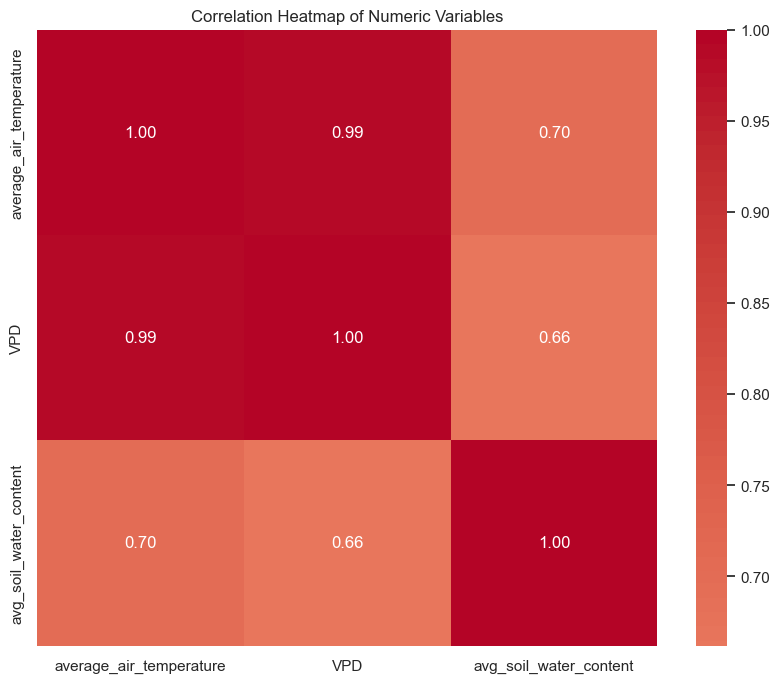

In [154]:
# Compute correlation matrix
corr = df[['average_air_temperature', 'VPD', 'avg_soil_water_content']].corr(numeric_only=True)

# Set up the figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr,
    annot=True,       # show correlation numbers
    fmt=".2f",        # format to 2 decimal places
    cmap="coolwarm",  # color map
    center=0          # center the colormap at 0
)

plt.title("Correlation Heatmap of Numeric Variables")
plt.show()


VPD (vapor pressure deficit) is calculated directly from air temperature and relative humidity:

VPD=SVP×(1−RH/100)

where SVP itself is an exponential function of temperature.

So, temperature drives most of the variation in VPD, especially if relative humidity doesn’t vary much. That explains the 99% correlation.

Dropping avg_air_temperature so as to not violate multicolinearity assumption:

## Models

**Initial MLR with Interaction Terms**

In [155]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula="""
        change_stem_radius ~ 
        VPD * avg_soil_water_content
    """,
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     change_stem_radius   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.939
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.53e-06
Time:                        15:40:13   Log-Likelihood:                 51105.
No. Observations:               12240   AIC:                        -1.022e+05
Df Residuals:                   12236   BIC:                        -1.022e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

This formula expands automatically to:

- main effects

- all two-way interactions

- three-way interaction:

Right now, the OLS treats every row as independent, but we actually have repeated measurements per tree (daily growth). That violates a key OLS assumption: independence of observations.

Adding dummy variable for each tree


**Fixed Effects Model by Tree**

In [156]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula='change_stem_radius ~ C(tree) + VPD * avg_soil_water_content',
    data=df
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     change_stem_radius   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     41.62
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:40:13   Log-Likelihood:                 52073.
No. Observations:               12240   AIC:                        -1.040e+05
Df Residuals:                   12188   BIC:                        -1.037e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

**Visualization of diminshing marginal returns of soil water at high VPD**

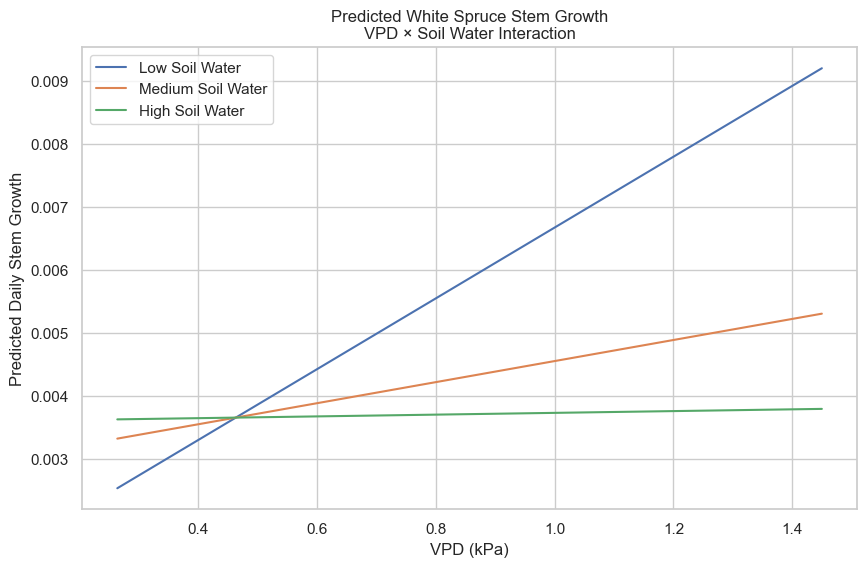

In [157]:
# Define soil water levels: low, medium, high
soil_low = df['avg_soil_water_content'].quantile(0.25)
soil_med = df['avg_soil_water_content'].quantile(0.50)
soil_high = df['avg_soil_water_content'].quantile(0.75)

soil_levels = [soil_low, soil_med, soil_high]
soil_labels = ['Low Soil Water', 'Medium Soil Water', 'High Soil Water']

# VPD range
vpd_vals = np.linspace(df['VPD'].min(), df['VPD'].max(), 100)

plt.figure(figsize=(10, 6))

for soil_val, label in zip(soil_levels, soil_labels):
    pred_df = pd.DataFrame({
        'VPD': vpd_vals,
        'avg_soil_water_content': soil_val,
        'tree': df['tree'].iloc[0]  # reference tree for fixed effects
    })
    pred_growth = model.predict(pred_df)
    plt.plot(vpd_vals, pred_growth, label=label)

plt.xlabel('VPD (kPa)')
plt.ylabel('Predicted Daily Stem Growth')
plt.title('Predicted White Spruce Stem Growth\nVPD × Soil Water Interaction')
plt.legend()
plt.grid(True)
plt.show()

- VPD has less positive effect at high soil water, because the tree can’t use extra water efficiently

**Mixed-effects model**

In [ ]:
import statsmodels.api as sm

md = sm.MixedLM.from_formula(
    'change_stem_radius ~ VPD * avg_soil_water_content',
    groups='tree',
    data=df
)
mdf = md.fit()
print(mdf.summary())


                Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  change_stem_radius
No. Observations:    12240    Method:              REML              
No. Groups:          49       Scale:               0.0000            
Min. group size:     7        Log-Likelihood:      51917.3211        
Max. group size:     584      Converged:           Yes               
Mean group size:     249.8                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.001    0.000  1.466 0.143 -0.000  0.001
VPD                         0.008    0.001 12.701 0.000  0.007  0.009
avg_soil_water_content      0.009    0.001  7.304 0.000  0.007  0.012
VPD:avg_soil_water_content -0.020    0.002 -9.902 0.000 -0.024 -0.016
tree Var                    0.000   

/Users/isaactabor/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<Axes: xlabel='change_stem_radius', ylabel='Density'>

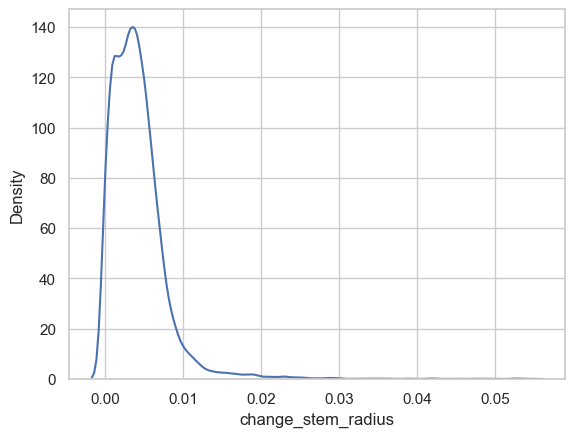

In [159]:
sns.kdeplot(df['change_stem_radius'])

In [160]:
df['ihs_change_stem_radius'] = np.arcsinh(df['change_stem_radius'])

In [161]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula='ihs_change_stem_radius ~ C(tree) + VPD * avg_soil_water_content',
    data=df
).fit()

print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     ihs_change_stem_radius   R-squared:                       0.148
Model:                                OLS   Adj. R-squared:                  0.145
Method:                     Least Squares   F-statistic:                     41.63
Date:                    Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                            15:40:14   Log-Likelihood:                 52075.
No. Observations:                   12240   AIC:                        -1.040e+05
Df Residuals:                       12188   BIC:                        -1.037e+05
Df Model:                              51                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

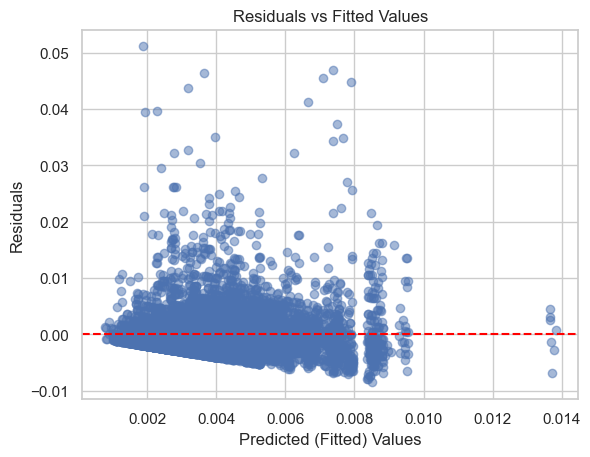

In [162]:
# Get fitted values on transformed scale
fitted_transformed = model.fittedvalues

# Inverse IHS transform 
# IHS inverse: sinh(fitted_transformed)
fitted_original = np.sinh(fitted_transformed)

# Calculate residuals on original scale
residuals_original = df['change_stem_radius'] - fitted_original

plt.axhline(0, color='red', linestyle='--')

plt.xlabel('Predicted (Fitted) Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
# Plot
plt.scatter(fitted_original, residuals_original, alpha=0.5)


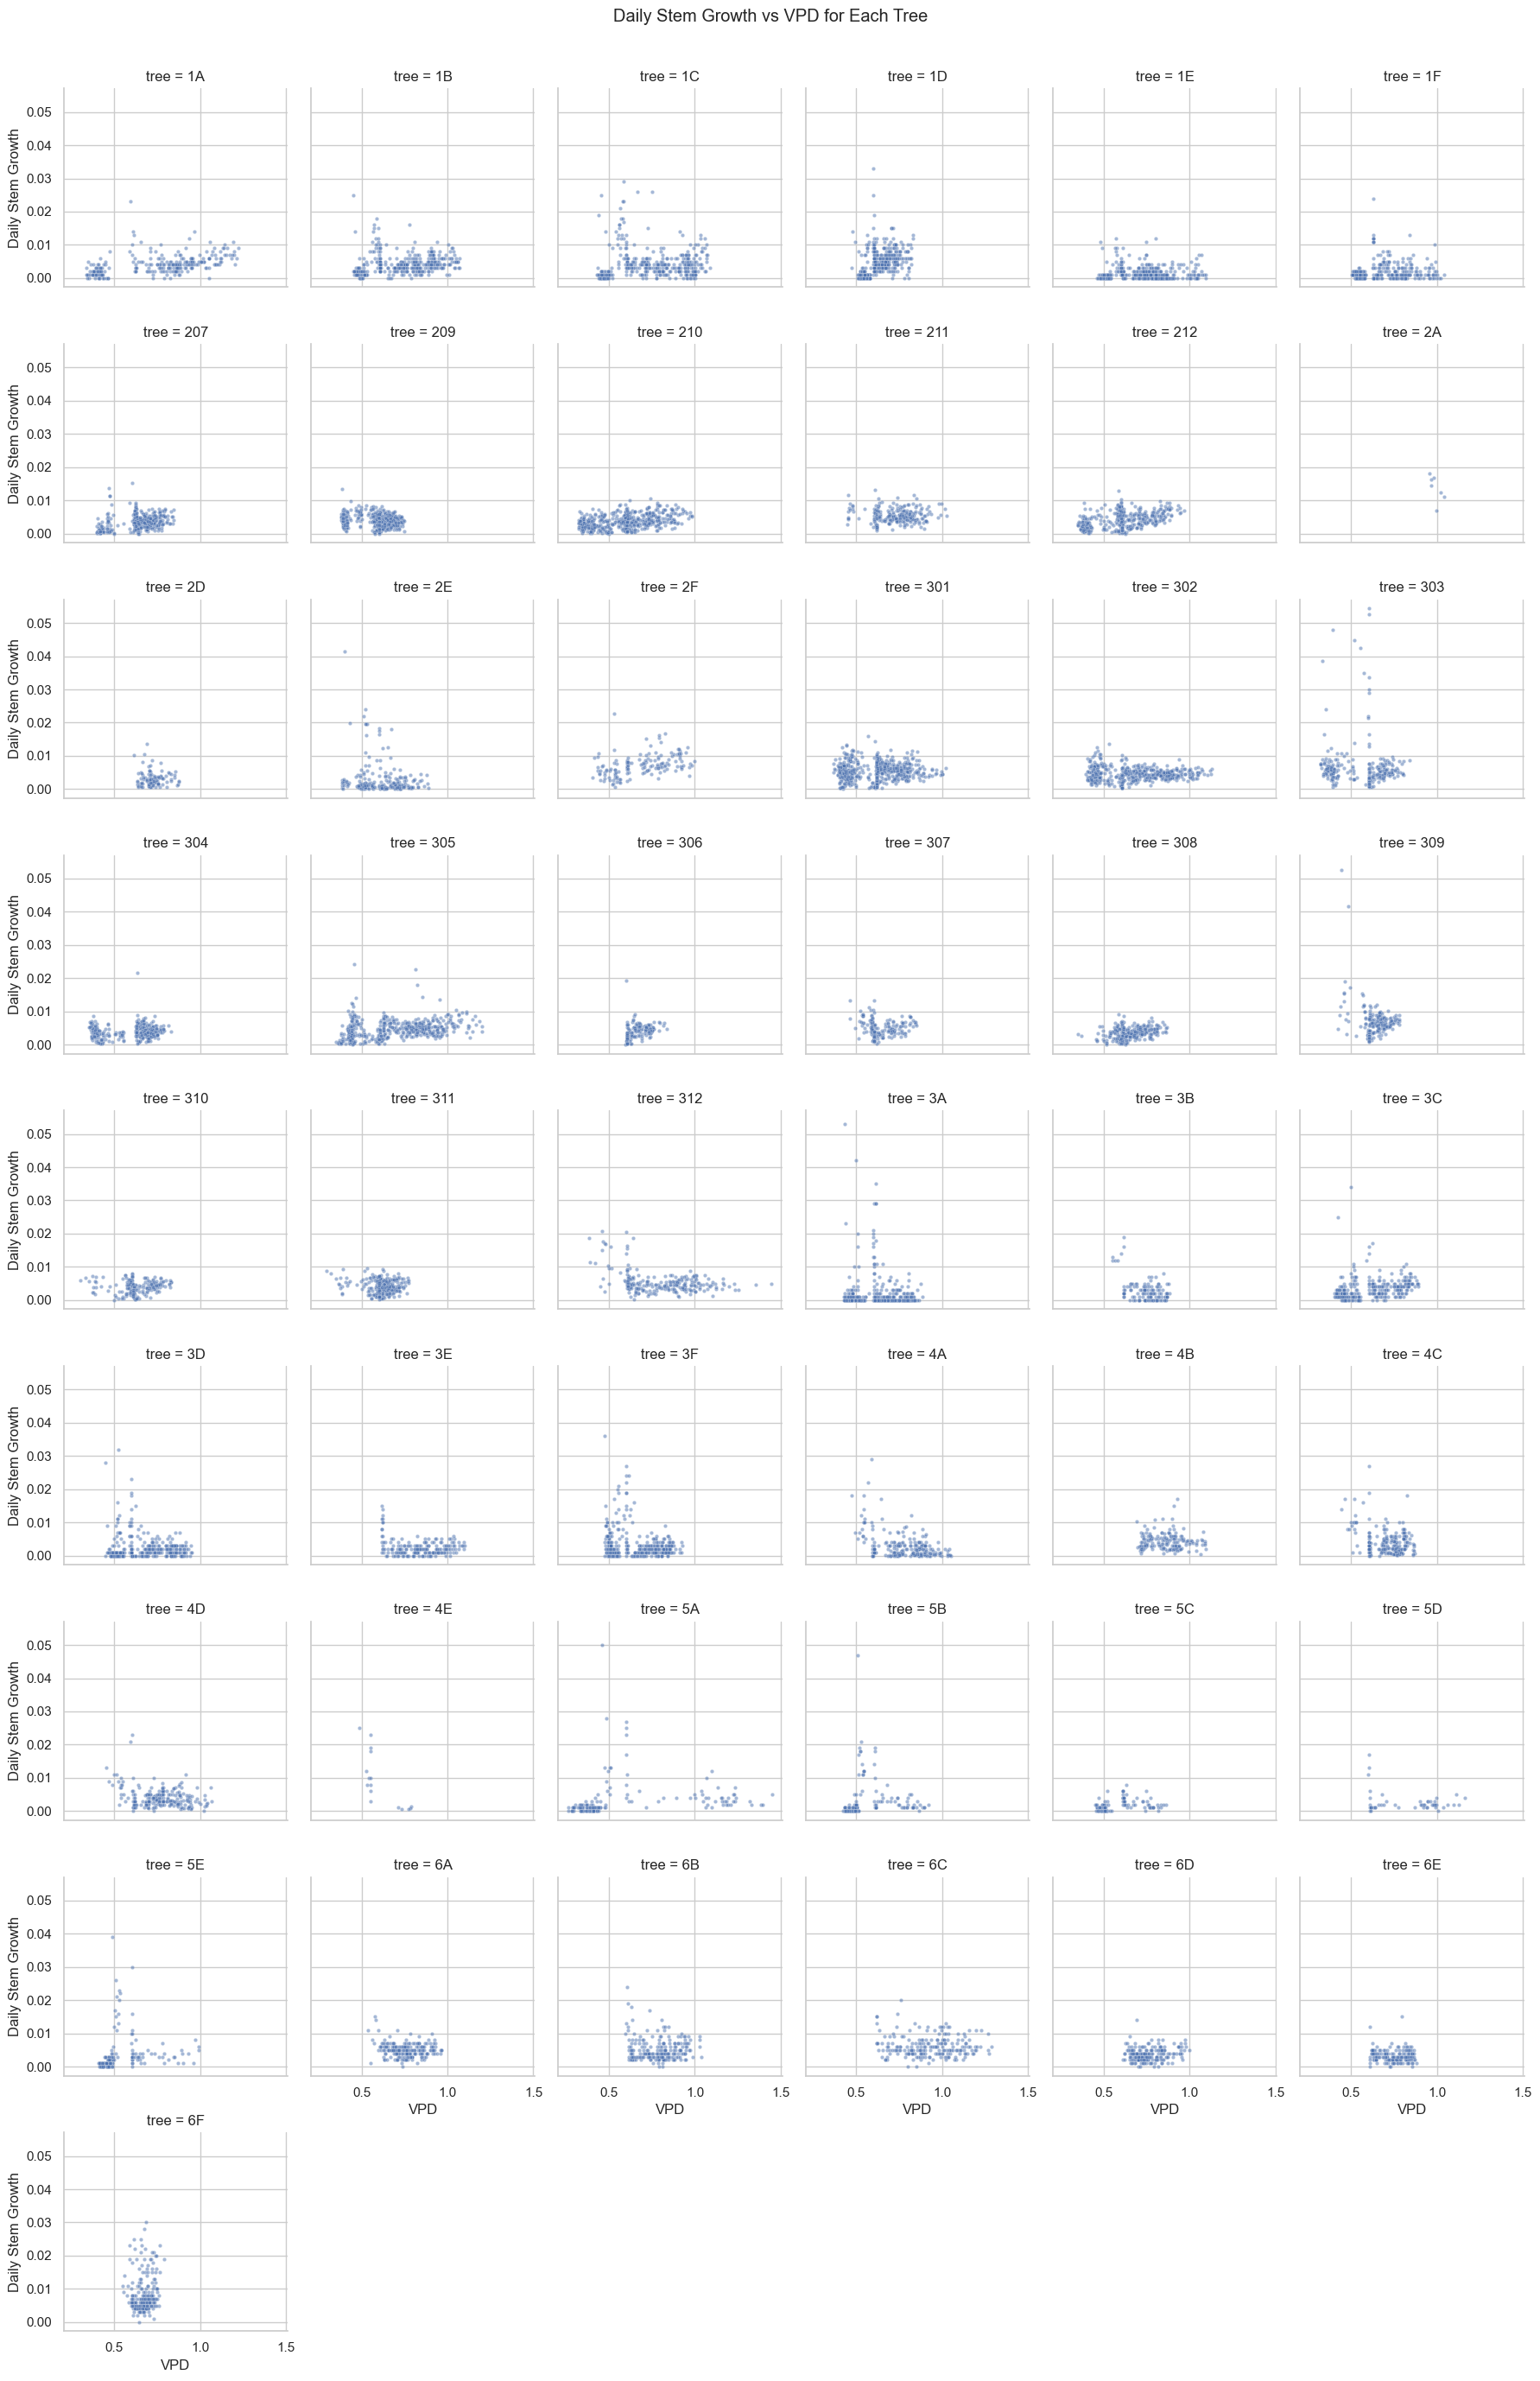

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.FacetGrid(
    df, 
    col="tree", 
    col_wrap=6,   # change to 5, 7, etc depending on number of trees
    height=3
)

g.map_dataframe(sns.scatterplot, x="VPD", y="change_stem_radius", s=10, alpha=0.5)
g.set_axis_labels("VPD", "Daily Stem Growth")
g.fig.suptitle("Daily Stem Growth vs VPD for Each Tree", y=1.02)
plt.show()


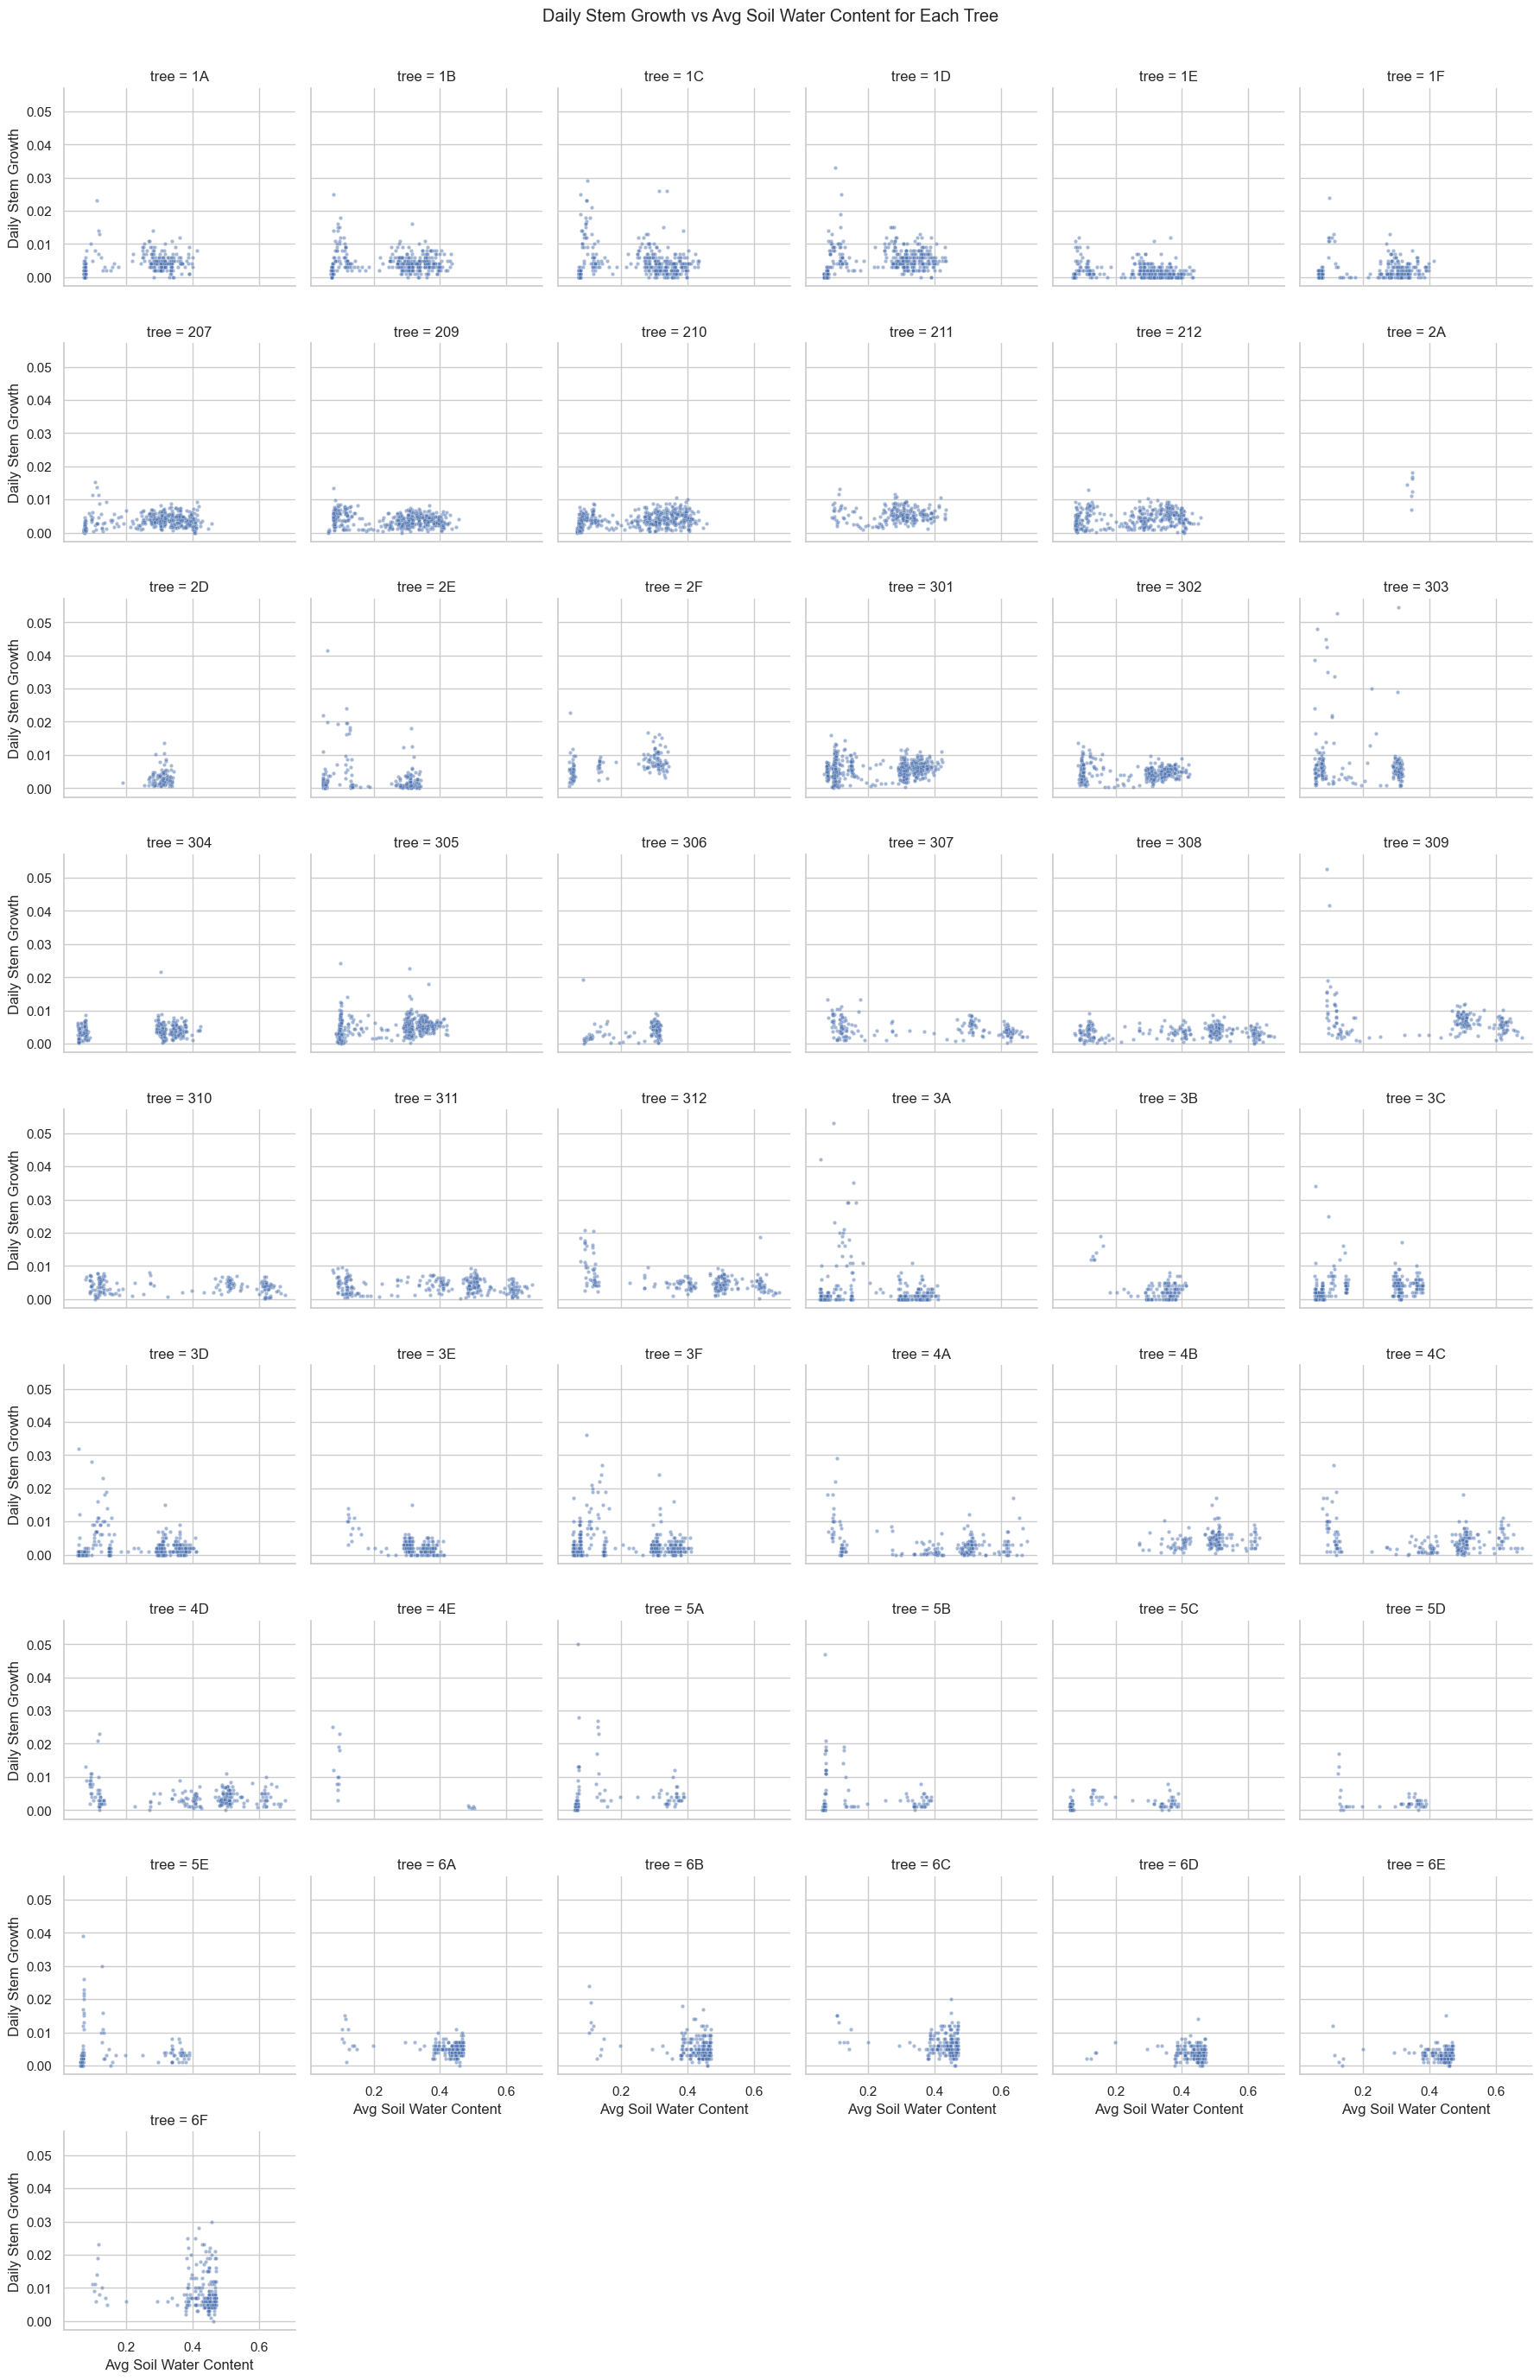

In [164]:
g = sns.FacetGrid(
    df, 
    col="tree", 
    col_wrap=6,
    height=3
)

g.map_dataframe(
    sns.scatterplot,
    x="avg_soil_water_content",
    y="change_stem_radius",
    s=10,
    alpha=0.5
)

g.set_axis_labels("Avg Soil Water Content", "Daily Stem Growth")
g.fig.suptitle("Daily Stem Growth vs Avg Soil Water Content for Each Tree", y=1.02)
plt.show()


In [165]:
df.columns

Index(['site', 'tree', 'plot', 'species', 'Date', 'longitude', 'latitude',
       'da', 'mo', 'wk', 'yr', 'average_stem_radius', 'change_stem_radius',
       'average_basal_area', 'change_basal_area', 'average_air_temperature',
       'average_air_pressure', 'average_humidity', 'avg_solar_irradiance',
       'avg_soil_water_content', 'freeze_flag', 'air_pressure_cat',
       'humidity_cat', 'solar_rank', 'solar_cat', 'soil_moist_cat',
       'growth_category', 'VPD', 'ihs_change_stem_radius'],
      dtype='object')

In [166]:
model = smf.ols(
    'ihs_change_stem_radius ~ C(tree) + C(yr) + average_stem_radius + VPD * avg_soil_water_content',
    data=df
).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     ihs_change_stem_radius   R-squared:                       0.155
Model:                                OLS   Adj. R-squared:                  0.151
Method:                     Least Squares   F-statistic:                     41.29
Date:                    Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                            15:40:34   Log-Likelihood:                 52120.
No. Observations:                   12240   AIC:                        -1.041e+05
Df Residuals:                       12185   BIC:                        -1.037e+05
Df Model:                              54                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [167]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,13627,13628,13629,13630,13631,13632,13633,13634,13635,13636
site,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK,...,AK,AK,AK,AK,AK,AK,AK,AK,AK,AK
tree,1A,1A,1A,1A,1A,1A,1A,1A,1A,1A,...,6F,6F,6F,6F,6F,6F,6F,6F,6F,6F
plot,1,1,1,1,1,1,1,1,1,1,...,6,6,6,6,6,6,6,6,6,6
species,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,...,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-01-01,2019-02-01,2019-05-01,2019-06-01,2018-07-01,2019-07-01,2018-08-01,2018-09-01,2019-01-02,2019-02-02,...,2019-05-30,2018-06-30,2019-06-30,2018-07-30,2019-07-30,2018-08-30,2019-05-31,2018-07-31,2019-07-31,2018-08-31
longitude,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571,...,-149.76103,-149.76103,-149.76103,-149.76103,-149.76103,-149.76103,-149.76103,-149.76103,-149.76103,-149.76103
latitude,68.018576,68.018576,68.018576,68.018576,68.018576,68.018576,68.018576,68.018576,68.018576,68.018576,...,67.972423,67.972423,67.972423,67.972423,67.972423,67.972423,67.972423,67.972423,67.972423,67.972423
da,1,1,1,1,1,1,1,1,2,2,...,30,30,30,30,30,30,31,31,31,31
mo,1,2,5,6,7,7,8,9,1,2,...,5,6,6,7,7,8,5,7,7,8
wk,1,5,18,22,26,26,31,35,1,5,...,22,26,26,31,31,35,22,31,31,35


<Axes: >

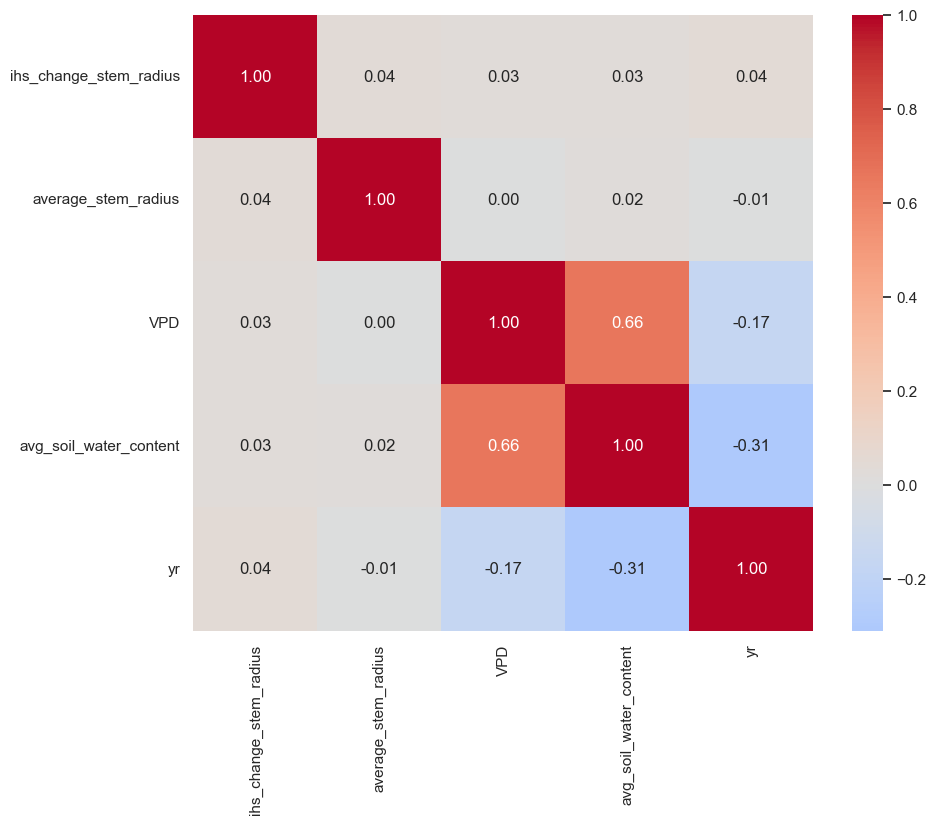

In [168]:
corr = df[['ihs_change_stem_radius', 'average_stem_radius', 'VPD', 'avg_soil_water_content', 'yr']].corr(numeric_only=True)

# Set up the figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr,
    annot=True,       # show correlation numbers
    fmt=".2f",        # format to 2 decimal places
    cmap="coolwarm",  # color map
    center=0          # center the colormap at 0
)

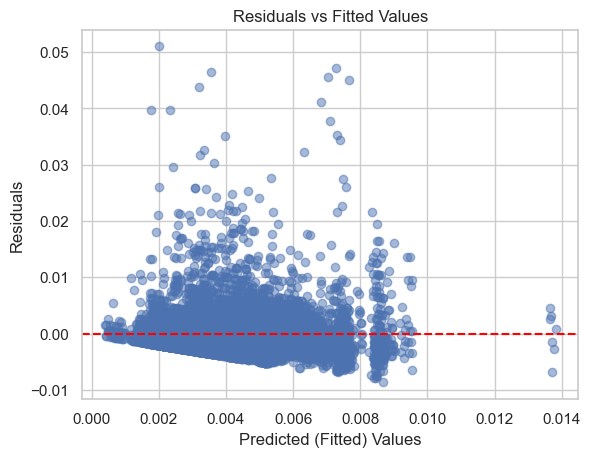

In [169]:
# Get fitted values on transformed scale
fitted_transformed = model.fittedvalues

# Inverse IHS transform 
# IHS inverse: sinh(fitted_transformed)
fitted_original = np.sinh(fitted_transformed)

# Calculate residuals on original scale
residuals_original = df['change_stem_radius'] - fitted_original

plt.axhline(0, color='red', linestyle='--')

plt.xlabel('Predicted (Fitted) Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
# Plot
plt.scatter(fitted_original, residuals_original, alpha=0.5)


In [170]:
df.columns

Index(['site', 'tree', 'plot', 'species', 'Date', 'longitude', 'latitude',
       'da', 'mo', 'wk', 'yr', 'average_stem_radius', 'change_stem_radius',
       'average_basal_area', 'change_basal_area', 'average_air_temperature',
       'average_air_pressure', 'average_humidity', 'avg_solar_irradiance',
       'avg_soil_water_content', 'freeze_flag', 'air_pressure_cat',
       'humidity_cat', 'solar_rank', 'solar_cat', 'soil_moist_cat',
       'growth_category', 'VPD', 'ihs_change_stem_radius'],
      dtype='object')

In [171]:
df['DBH_cm'] = 2 * df['average_stem_radius']
def categorize_tree(dbh):
    if dbh < 5:
        return "too_small_excluded"
    elif 5 <= dbh <= 10:
        return "sapling"
    else:
        return "mature"

df['tree_size_class'] = df['DBH_cm'].apply(categorize_tree)


In [172]:
# get first daily record for each tree
initial_df = (
    df.sort_values(['tree', 'Date'])
      .groupby('tree')
      .first()[['DBH_cm']]
)

initial_df['tree_size_class'] = initial_df['DBH_cm'].apply(categorize_tree)


In [173]:
df = df.merge(
    initial_df['tree_size_class'],
    left_on='tree',
    right_index=True,
    how='left'
)


In [175]:
import statsmodels.api as sm

md = sm.MixedLM.from_formula(
    'ihs_change_stem_radius ~ VPD * avg_soil_water_content + average_stem_radius + C(yr) + C(tree_size_class_x)',
    groups='tree',
    re_formula="~VPD + avg_soil_water_content",  # optional random slopes
    data=df
)
mdf = md.fit()
print(mdf.summary())


                   Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   ihs_change_stem_radius
No. Observations:     12240     Method:               REML                  
No. Groups:           49        Scale:                0.0000                
Min. group size:      7         Log-Likelihood:       52150.6623            
Max. group size:      584       Converged:            Yes                   
Mean group size:      249.8                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.004    0.001  3.234 0.001  0.002  0.006
C(yr)[T.2018]                      0.001    0.000  8.392 0.000  0.001  0.001
C(yr)[T.2019]                      0.001    0.000  9.684 0.000  0.001  0.001
C(tree_size_class_x

/Users/isaactabor/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [179]:
model = smf.ols(
    'ihs_change_stem_radius ~ VPD * avg_soil_water_content + C(tree_size_class_x) + C(tree)',
    data=df
).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     ihs_change_stem_radius   R-squared:                       0.149
Model:                                OLS   Adj. R-squared:                  0.145
Method:                     Least Squares   F-statistic:                     40.96
Date:                    Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                            15:50:47   Log-Likelihood:                 52078.
No. Observations:                   12240   AIC:                        -1.040e+05
Df Residuals:                       12187   BIC:                        -1.037e+05
Df Model:                              52                                         
Covariance Type:                nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [181]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])


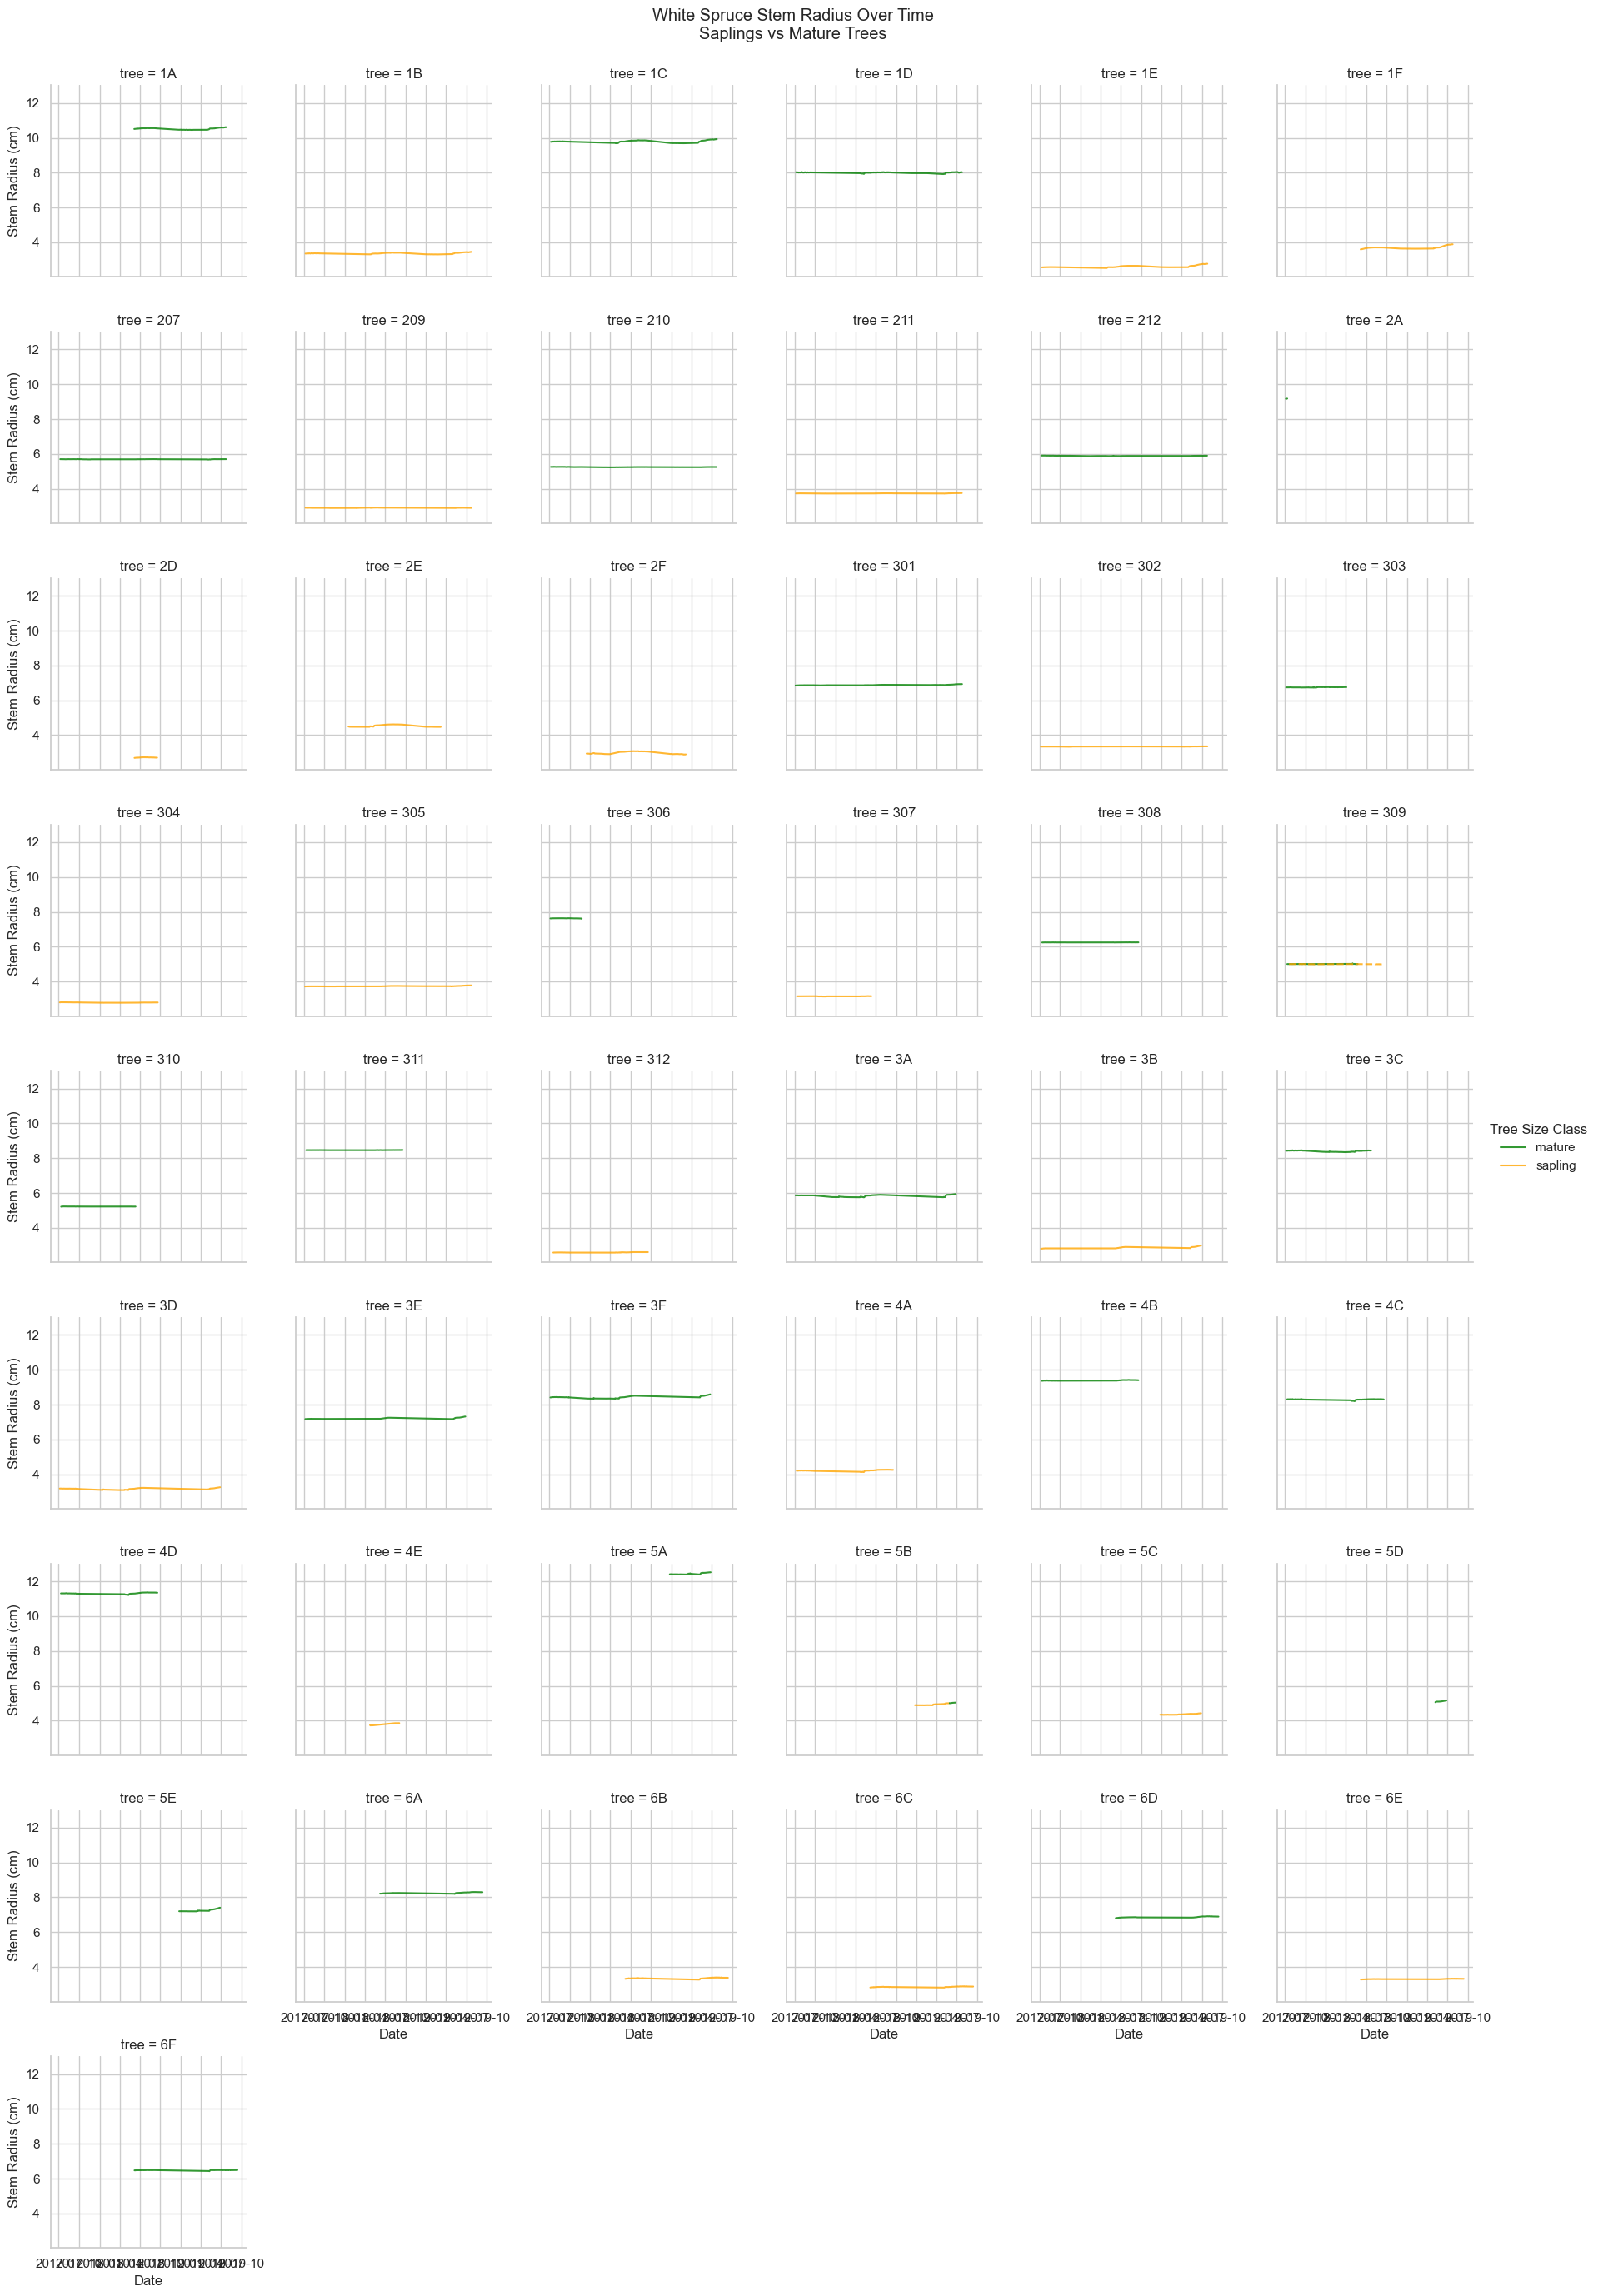

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set up FacetGrid: one facet per tree
g = sns.FacetGrid(
    df,
    col='tree',
    col_wrap=6,    # adjust based on number of trees per row
    height=3,
    sharey=True
)

# Map lineplot to each facet
g.map_dataframe(
    sns.lineplot,
    x='Date',
    y='average_stem_radius',
    hue='tree_size_class_x',   # color by sapling vs mature
    style='tree_size_class_x', # optional: differentiate by line style
    palette={'sapling': 'orange', 'mature': 'green'},
    alpha=0.8
)

# Axis labels and title
g.set_axis_labels('Date', 'Stem Radius (cm)')
g.add_legend(title='Tree Size Class')
g.fig.suptitle('White Spruce Stem Radius Over Time\nSaplings vs Mature Trees', y=1.02)

plt.show()
